In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric_1.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
solvers[.66].medium['cloud'].reff.data[np.where(carved_volume.mask.data == 0)] = 0

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    maxnphase=1e9,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

# We are using the ground_truth rte_grid.
#dataset = dataset.reset_coords(['reff'], drop=True)

In [2]:
def train_density(solvers_reconstruct_reff, i):
    uncertainty_density = at3d.uncertainties.NullUncertainty('L2',i*1e10) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_density)

    data_with_reff = solvers_reconstruct_reff[.66].medium['cloud'].drop_vars("density")

    micro_grid_with_reff = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_reff
    )

    relative_scaling_density = 1
    unknown_scatterer_density = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_reff,
        density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_density * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_density = at3d.containers.SolversDict()

    state_gen_density = at3d.medium.StateGenerator(solvers_reconstruct_density,
                                            unknown_scatterer_density, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_density, max_bounds_density = state_gen_density.transform_bounds()
    forward_sensors_density = sensors.make_forward_sensors()

    initial_gridded_density = solvers_reconstruct_reff[.66].medium['cloud'].density.data
    initial_1d_density = state_gen_density._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
    x2 = state_gen_density._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)

    objective_function_density = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_density, forward_sensors_density, unknown_scatterer_density, state_gen_density,
    state_gen_density.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_density, max_bounds=max_bounds_density)


    def plot_density(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_density[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_density[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_density = at3d.callback.CallbackFn(plot_density)

    import warnings
    optimizer_density = at3d.optimize.Optimizer(objective_function_density,callback_fn=callback_density, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_density._options['maxiter'] = 1
    result_density = optimizer_density.minimize(x2)
    return solvers_reconstruct_density

In [3]:
def train_reff(solvers_reconstruct_density, i):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e14) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = 1
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    regularization = at3d.regularization.SpatialSmoothing(state_gen_reff, "cloud", "reff", 15.0, direction_weights=[1,1,1])

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff, prior_fn=regularization, callback_fn=callback_reff, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 1
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff

In [4]:
def train_reff_full(solvers_reconstruct_density, i):
    uncertainty_reff = at3d.uncertainties.NullUncertainty('L2',i*1e14) #replaces original uncertainty
    sensors.add_uncertainty_model('MSPI', uncertainty_reff)

    data_with_extinction = solvers_reconstruct_density[.66].medium['cloud'].drop_vars("reff")

    micro_grid_with_extinction = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, data_with_extinction
    )

    relative_scaling_reff = 1
    unknown_scatterer_reff = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(micro_grid_with_extinction,
        reff=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        )
    )

    # now we form state_gen which updates the solvers with an input_state.
    solvers_reconstruct_reff = at3d.containers.SolversDict()

    state_gen_reff = at3d.medium.StateGenerator(solvers_reconstruct_reff,
                                            unknown_scatterer_reff, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)

    min_bounds_reff, max_bounds_reff = state_gen_reff.transform_bounds()
    forward_sensors_reff = sensors.make_forward_sensors()

    regularization = at3d.regularization.SpatialSmoothing(state_gen_reff, "cloud", "reff", 20.0, direction_weights=[0,0,1])

    initial_gridded_reff = solvers_reconstruct_density[.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x1 = state_gen_reff._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function_reff = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct_reff, forward_sensors_reff, unknown_scatterer_reff, state_gen_reff,
    state_gen_reff.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds_reff, max_bounds=max_bounds_reff)


    def plot_reff(optimizer):
        fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
        # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
        #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
        # axs[0].plot([0,130],[0,130])
        axs[1].plot(solvers_reconstruct_reff[0.66].medium['cloud'].density.data.ravel(), 
                solvers[0.66].medium['cloud'].density.data.ravel(),'x')
        axs[1].plot([0,2],[0,2])
        axs[0].plot(solvers_reconstruct_reff[0.66].medium['cloud'].reff.data.ravel(), 
                solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
        axs[0].plot([0,20],[0,20])
        #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
                #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
        #axs[3].plot([0,30],[0,30])
        # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
        #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        #         uncertainty_kwargs={'add_noise': False})()
        # grads = optimizer_reff.objective(optimizer_reff._state)[1]
        # print(grads.shape)
        # print(grads.mean())
        # print(grads.std())
        py.show()
        return {'None': None}
    callback_reff = at3d.callback.CallbackFn(plot_reff)

    import warnings
    optimizer_reff = at3d.optimize.Optimizer(objective_function_reff, prior_fn=regularization, callback_fn=callback_reff, options={'maxiter': 100, 'maxls': 10, 'disp': True})
    warnings.filterwarnings('ignore')
    optimizer_reff._options['maxiter'] = 1
    result_reff = optimizer_reff.minimize(x1)
    return solvers_reconstruct_reff

------ Iter 0 ------
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  2.15961D+02    |proj g|=  7.63406D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.292  0.344E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -2.597  0.338E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -4.284  0.322E-01    31984   228.06  0.891   [Radiance 0.660 micron]
     4  -4.294  0.300E-01    31999   228.07  0.891   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000051   [Radia

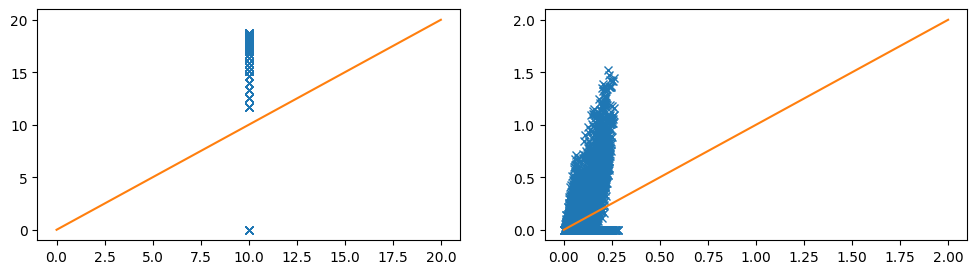


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4      1     0     0   2.751D+00   1.585D+02
  F =   158.47800077653557     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.727  0.105E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.549  0.105E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -5.796  0.105E-01    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

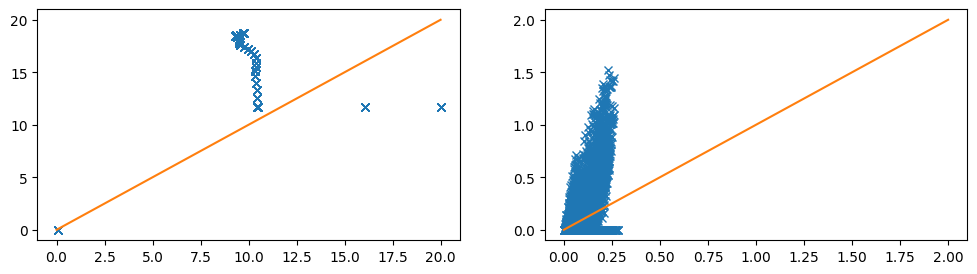


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      4      2     0     1   6.343D+00   1.708D+06
  F =   1707950.2246738009     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.730  0.900E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -3.563  0.900E-02    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -5.835  0.900E-02    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

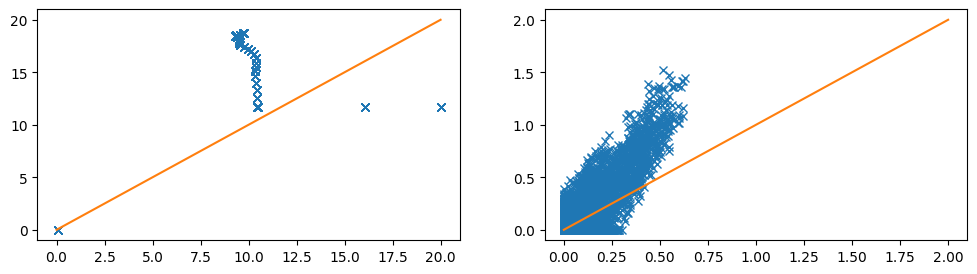


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      2  13396     0 13395   2.017D+00   2.738D+01
  F =   27.382093024760220     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.712  0.449E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     2  -3.658  0.446E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     3  -5.555  0.446E-02    31968   124.55  0.487   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

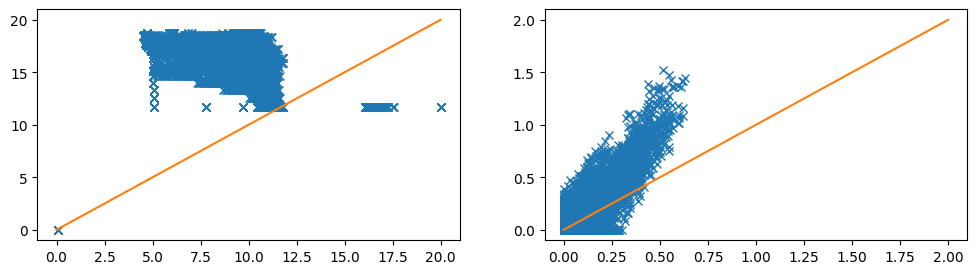


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2441     0  2440   2.548D+01   4.073D+05
  F =   407317.98729478614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.710  0.451E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     2  -3.650  0.448E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     3  -5.541  0.448E-02    31968   124.55  0.487   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

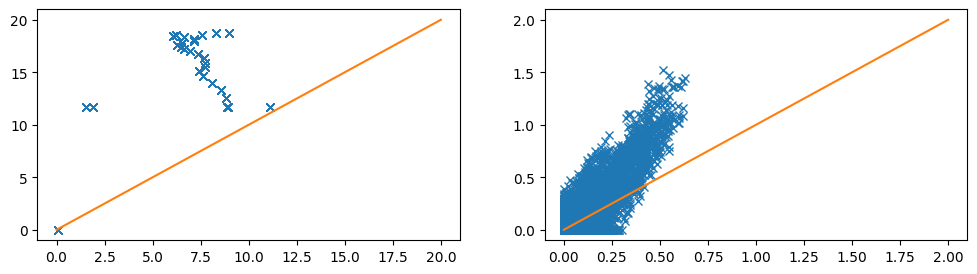

------ Iter 1 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      2      1     0     0   1.200D+01   3.785D+05
  F =   378497.12363432028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.698  0.935E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     2  -3.618  0.932E-02    31968   124.55  0.487   [Radiance 0.660 micron]
     3  -5.483  0.932E-02    31968   124.55  0.487   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS

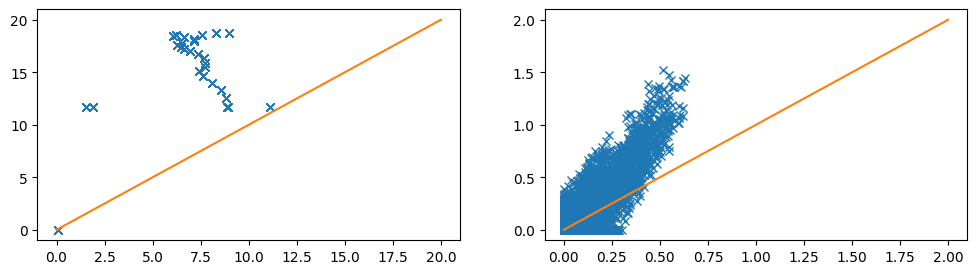


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      9   4945     0  6350   2.681D+00   3.616D+01
  F =   36.161768452612634     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.700  0.925E-02    31968   217.18  0.848   [Radiance 0.660 micron]
     2  -3.618  0.922E-02    31968   217.18  0.848   [Radiance 0.660 micron]
     3  -5.484  0.922E-02    31968   217.18  0.848   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

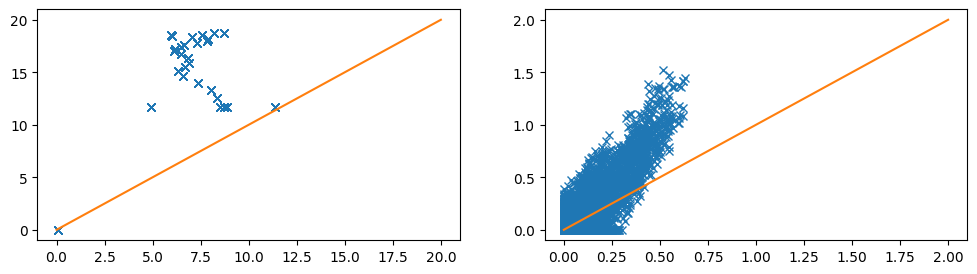


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      4      1     0     0   6.276D+00   4.842D+05
  F =   484222.83895930392     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.700  0.469E-02    31968   217.18  0.848   [Radiance 0.660 micron]
     2  -3.619  0.467E-02    31968   217.18  0.848   [Radiance 0.660 micron]
     3  -5.491  0.467E-02    31968   217.18  0.848   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

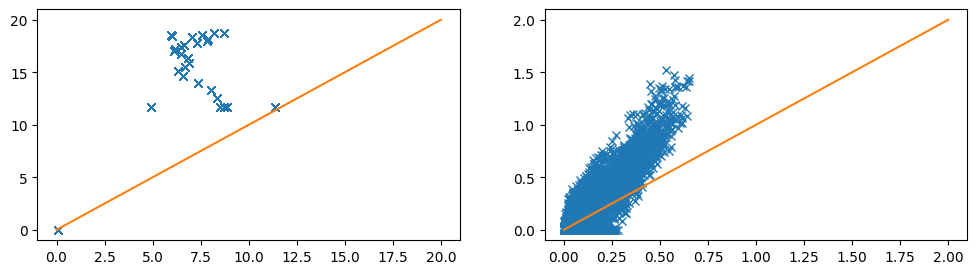


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      5   5148     0  6464   1.291D+00   2.665D+01
  F =   26.646246185630080     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.704  0.423E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     2  -3.602  0.419E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     3  -5.508  0.419E-02    31968   217.87  0.851   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

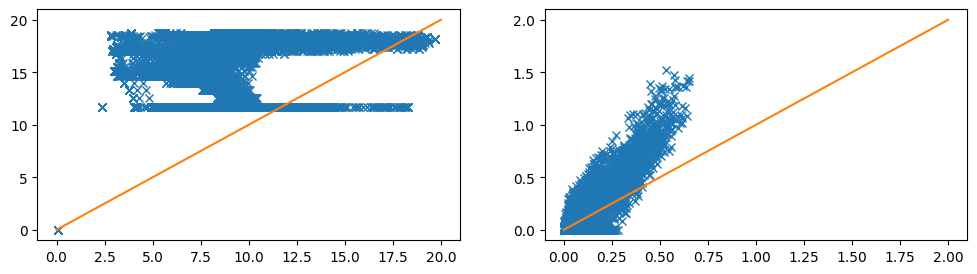


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      3   2123     0  2122   2.716D+01   3.115D+05
  F =   311547.85711641831     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.708  0.397E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     2  -3.614  0.395E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     3  -5.530  0.395E-02    31968   217.87  0.851   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

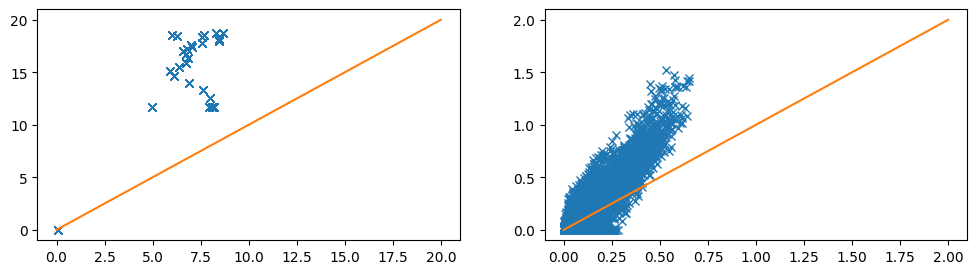

------ Iter 2 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      4      1     0     0   3.801D+00   3.995D+05
  F =   399547.35437599302     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.707  0.430E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     2  -3.608  0.428E-02    31968   217.87  0.851   [Radiance 0.660 micron]
     3  -5.520  0.428E-02    31968   217.87  0.851   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS

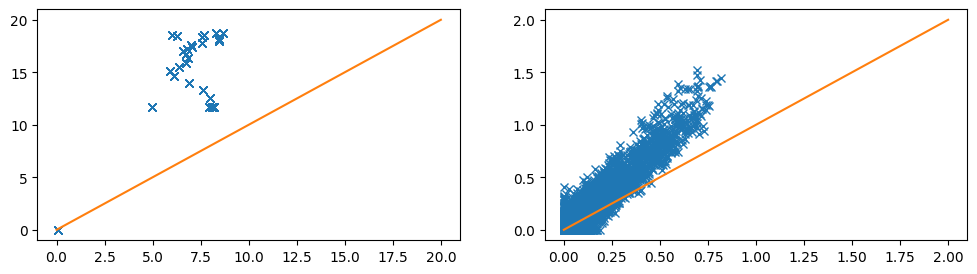


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      2  20628     0 21889   4.517D+00   1.949D+01
  F =   19.492090783948679     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.635  0.689E-02    31968    58.92  0.230   [Radiance 0.660 micron]
     2  -3.570  0.677E-02    31968    58.92  0.230   [Radiance 0.660 micron]
     3  -5.486  0.677E-02    31968    58.92  0.230   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

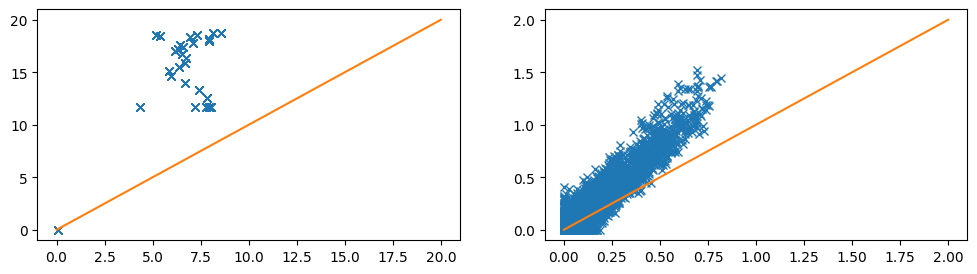


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      5      3     0     2   5.056D+00   2.934D+05
  F =   293418.20225132850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.630  0.707E-02    31968    58.92  0.230   [Radiance 0.660 micron]
     2  -3.559  0.694E-02    31968    58.92  0.230   [Radiance 0.660 micron]
     3  -5.466  0.694E-02    31968    58.92  0.230   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

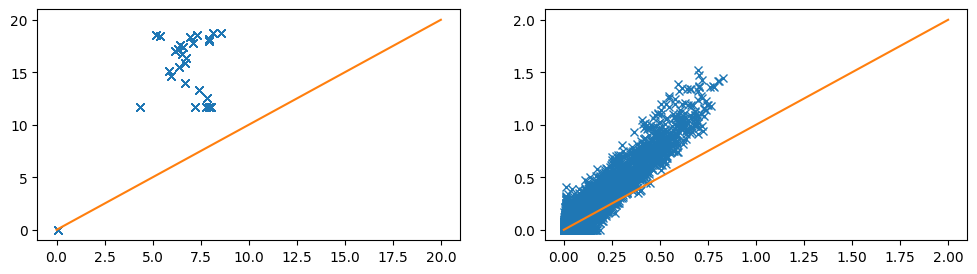


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7   1437     0  3295   2.238D+00   1.261D+01
  F =   12.607854303339217     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.656  0.677E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     2  -3.573  0.665E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     3  -5.479  0.665E-02    31968   213.68  0.835   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

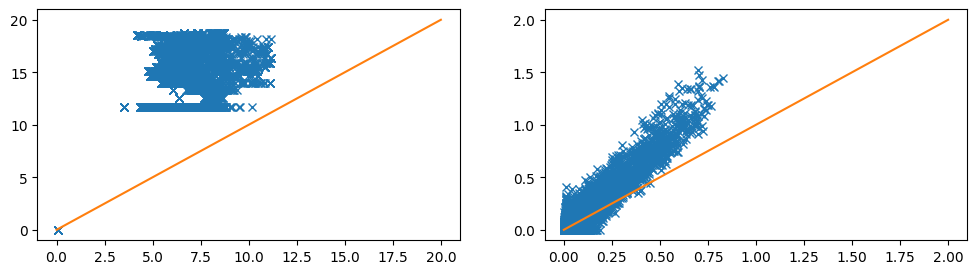


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   3071     0  3070   2.580D+01   1.484D+05
  F =   148415.47238963319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.654  0.678E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     2  -3.571  0.666E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     3  -5.474  0.666E-02    31968   213.68  0.835   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.654  0.678E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     2  -3.571  0.666E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     3  -5.474  0.666E-02    31968   213.68  0.835   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0      1859 variables are exactly at the bounds

At iterate    0    f=  1.82644D+01    |proj g|=  2.81789D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.566  0.722E-02    31968   162.42  0.634   [Radiance 0.660 micron]
     2  -3.314  0.724E-02    31968   162.42  0.634   [Radiance 0.660 micron]
     3  -5.121  0.724E-02    31968   162.42  0.634   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000008   [Radiance 0.660 micron]
  !

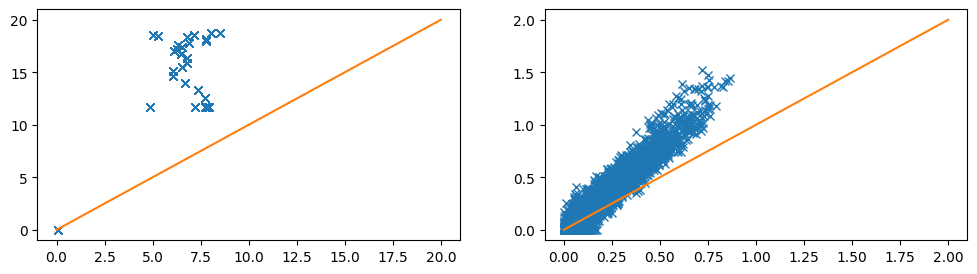


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      5   6635     0  8493   1.507D+00   1.574D+01
  F =   15.736332326216596     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.659  0.570E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     2  -3.558  0.566E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     3  -5.451  0.566E-02    31968   213.68  0.835   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

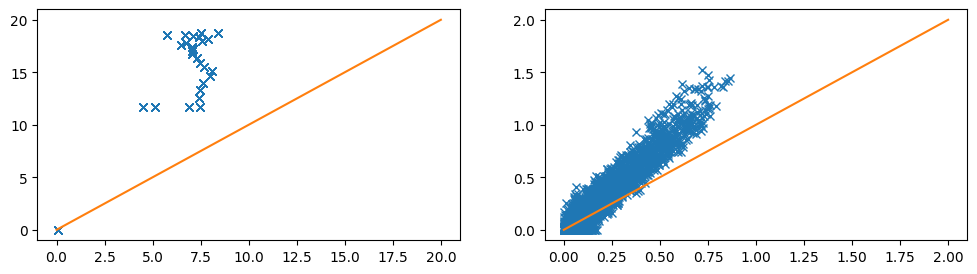


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      4      1     0     0   4.414D+00   2.603D+05
  F =   260336.57398870430     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.664  0.634E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     2  -3.571  0.623E-02    31968   213.68  0.835   [Radiance 0.660 micron]
     3  -5.470  0.623E-02    31968   213.68  0.835   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000003   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

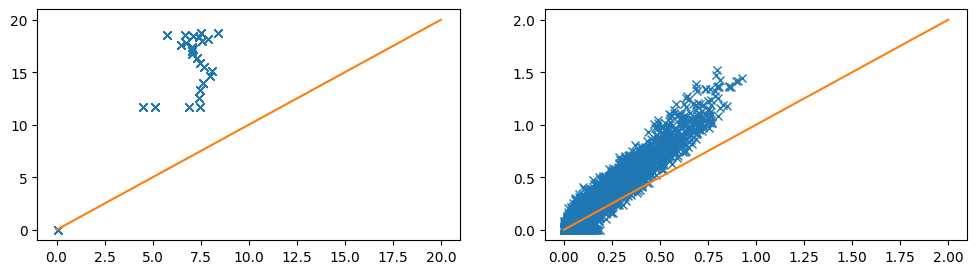


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4  19626     0 20554   2.243D+00   1.177D+01
  F =   11.765536342579805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.636  0.633E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     2  -3.521  0.636E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     3  -5.371  0.635E-02    31968   220.87  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

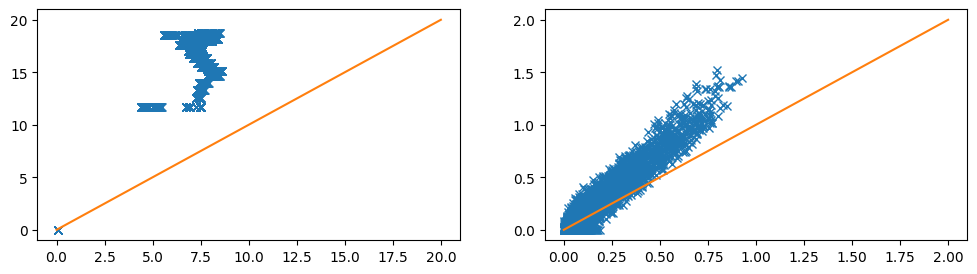


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      3   2624     0  2623   2.368D+01   1.836D+05
  F =   183582.68975395244     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.636  0.633E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     2  -3.521  0.635E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     3  -5.372  0.635E-02    31968   220.87  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

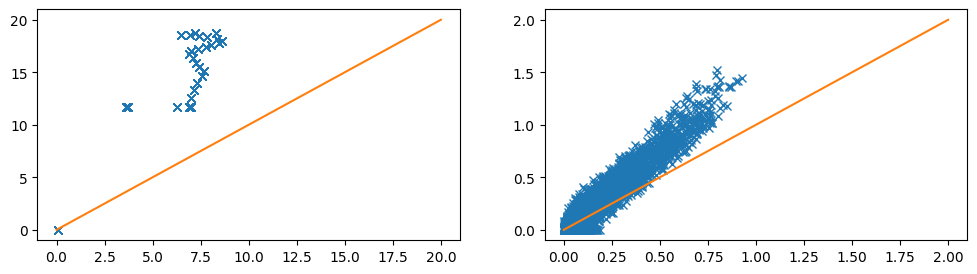

------ Iter 4 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      4      1     0     0   1.927D+00   2.264D+05
  F =   226394.76778660732     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.642  0.623E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     2  -3.532  0.625E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     3  -5.394  0.625E-02    31968   220.87  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS

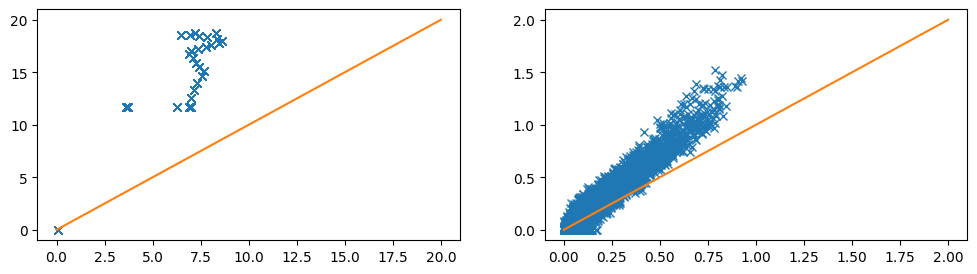


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      5  21006     0 21934   1.712D+00   1.377D+01
  F =   13.770159829113330     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.635  0.640E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     2  -3.529  0.642E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     3  -5.394  0.642E-02    31968   220.87  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1     11      1     0     0   1.944D+00   2.512D+05
  F =   251198.49017814611     

ABNORMAL_TERMINATION_IN_LNSRCH                              
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.635  0.640E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     2  -3.529  0.642E-02    31968   220.87  0.863   [Radiance 0.660 micron]
     3  -5.394  0.642E-02    31968   220.87  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

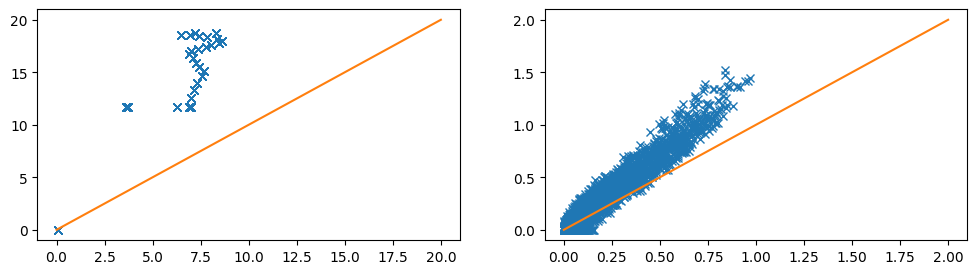


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4  22164     0 23087   2.386D+00   1.206D+01
  F =   12.056634074386215     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.623  0.712E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     2  -3.515  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     3  -5.352  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

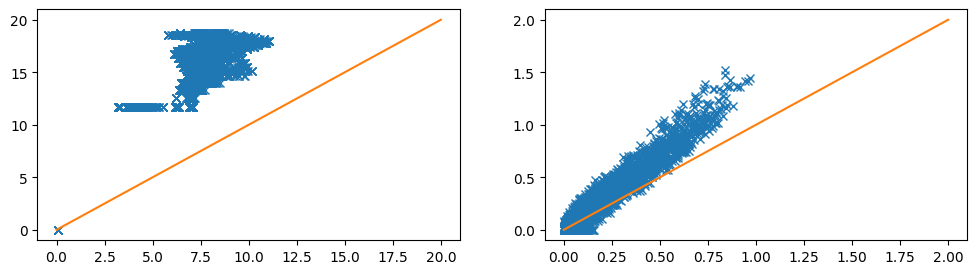


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   3131     0  3130   2.422D+01   1.778D+05
  F =   177763.32703221746     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.623  0.711E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     2  -3.515  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     3  -5.352  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.623  0.711E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     2  -3.515  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
     3  -5.352  0.714E-02    31968   220.91  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       924 variables are exactly at the bounds

At iterate    0    f=  1.79582D+01    |proj g|=  3.49123D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.465  0.759E-02    31968    67.87  0.265   [Radiance 0.660 micron]
     2  -3.122  0.773E-02    31968    67.87  0.265   [Radiance 0.660 micron]
     3  -4.968  0.773E-02    31968    67.87  0.265   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000011   [Radiance 0.660 micron]
  !

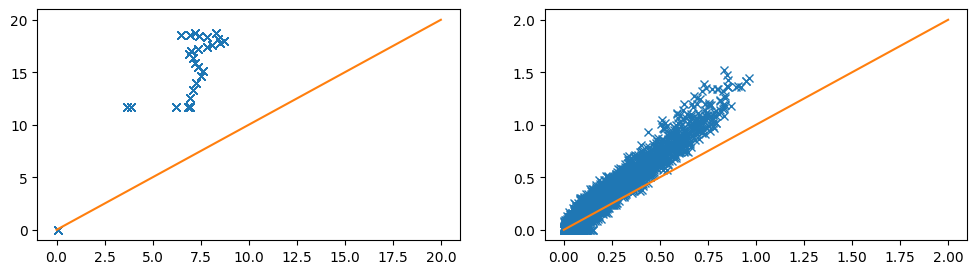


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7  19813     0 20731   1.816D+00   1.459D+01
  F =   14.586519166226251     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.623  0.710E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     2  -3.515  0.712E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     3  -5.362  0.712E-02    31968   220.94  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.623  0.710E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     2  -3.515  0.712E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     3  -5.362  0.712E-02    31968   220.94  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       919 variables are exactly at the bounds

At iterate    0    f=  1.45865D+01    |proj g|=  1.81619D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.616  0.826E-02    31968    44.86  0.175   [Radiance 0.660 micron]
     2  -3.573  0.829E-02    31968    44.86  0.175   [Radiance 0.660 micron]
     3  -5.452  0.829E-02    31968    44.86  0.175   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
  !

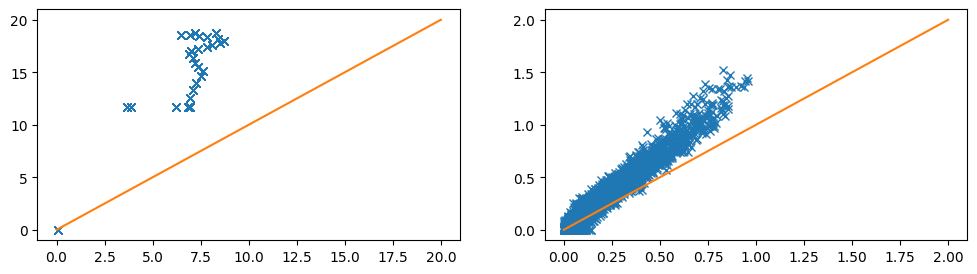


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      5  22791     0 23709   2.201D+00   1.236D+01
  F =   12.358204406287467     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.625  0.728E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     2  -3.527  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     3  -5.381  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

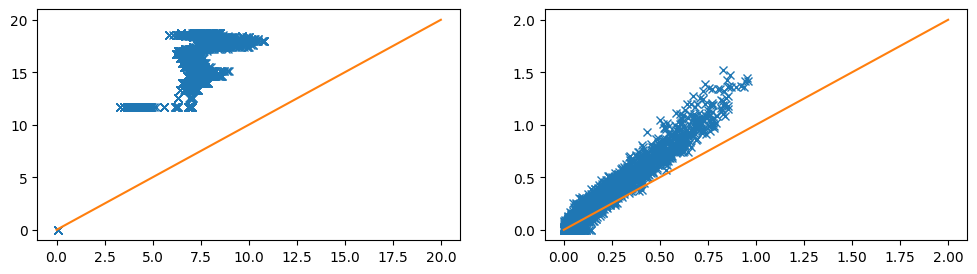


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2488     0  2487   2.414D+01   1.854D+05
  F =   185392.02034083326     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.624  0.729E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     2  -3.527  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     3  -5.380  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.624  0.729E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     2  -3.527  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
     3  -5.380  0.731E-02    31968   220.94  0.863   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       919 variables are exactly at the bounds

At iterate    0    f=  1.83937D+01    |proj g|=  3.01732D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.480  0.109E-01    31968    50.11  0.196   [Radiance 0.660 micron]
     2  -3.229  0.109E-01    31968    50.11  0.196   [Radiance 0.660 micron]
     3  -4.979  0.109E-01    31968    50.11  0.196   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  !

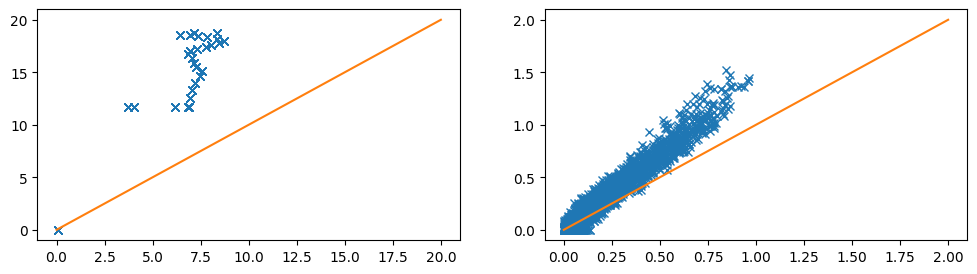


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7  22142     0 23029   1.199D+00   1.732D+01
  F =   17.319541423937920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.619  0.745E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     2  -3.515  0.747E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     3  -5.364  0.747E-02    31968   221.18  0.864   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.619  0.745E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     2  -3.515  0.747E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     3  -5.364  0.747E-02    31968   221.18  0.864   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       888 variables are exactly at the bounds

At iterate    0    f=  1.73195D+01    |proj g|=  1.19872D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.586  0.926E-02    31968    42.39  0.166   [Radiance 0.660 micron]
     2  -3.513  0.929E-02    31968    42.39  0.166   [Radiance 0.660 micron]
     3  -5.355  0.929E-02    31968    42.39  0.166   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
  !

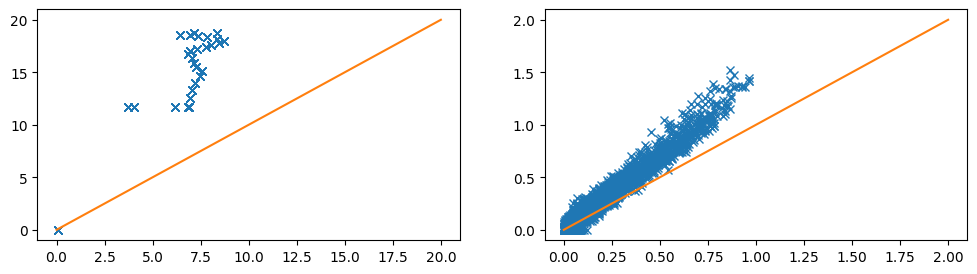


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4  23142     0 24029   4.755D+00   1.451D+01
  F =   14.509119134142990     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.613  0.797E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     2  -3.517  0.799E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     3  -5.364  0.799E-02    31968   221.18  0.864   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

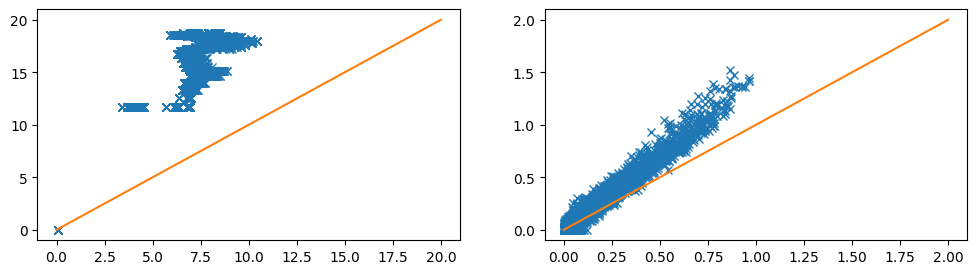


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2558     0  2557   2.409D+01   2.103D+05
  F =   210342.72949172446     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.613  0.798E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     2  -3.517  0.800E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     3  -5.363  0.800E-02    31968   221.18  0.864   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.613  0.798E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     2  -3.517  0.800E-02    31968   221.18  0.864   [Radiance 0.660 micron]
     3  -5.363  0.800E-02    31968   221.18  0.864   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       888 variables are exactly at the bounds

At iterate    0    f=  2.16051D+01    |proj g|=  6.88365D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.371  0.230E-01    31968    53.76  0.210   [Radiance 0.660 micron]
     2  -2.923  0.217E-01    31968    53.76  0.210   [Radiance 0.660 micron]
     3  -4.614  0.217E-01    31968    53.76  0.210   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000024   [Radiance 0.660 micron]
  !

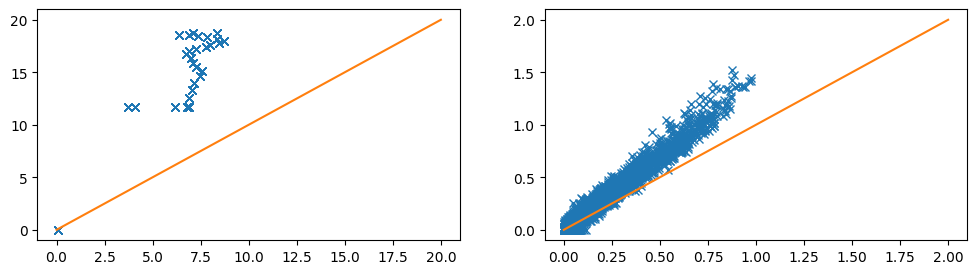


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      8  21726     0 22557   1.802D+00   2.060D+01
  F =   20.599901071632924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.608  0.806E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.506  0.809E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.351  0.809E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

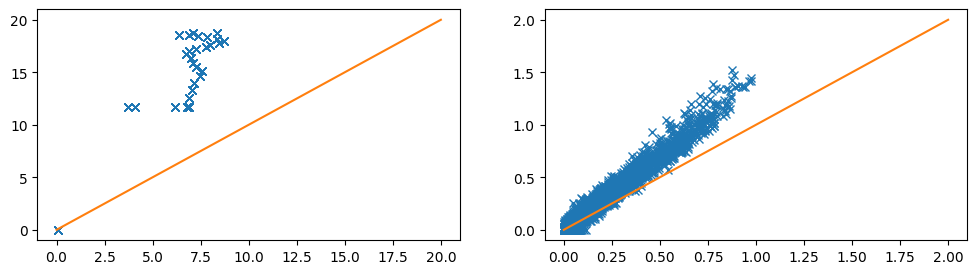


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      9      1     0     0   2.082D+00   3.186D+05
  F =   318629.41332678788     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.608  0.806E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.506  0.809E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.351  0.809E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

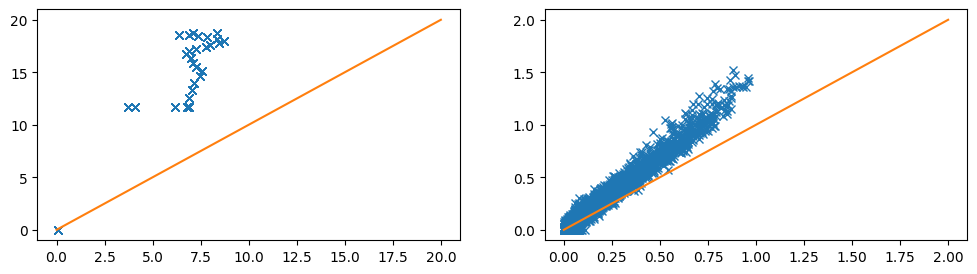


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      6  23184     0 24015   3.322D+00   1.947D+01
  F =   19.474606805759674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.608  0.813E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.509  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.354  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

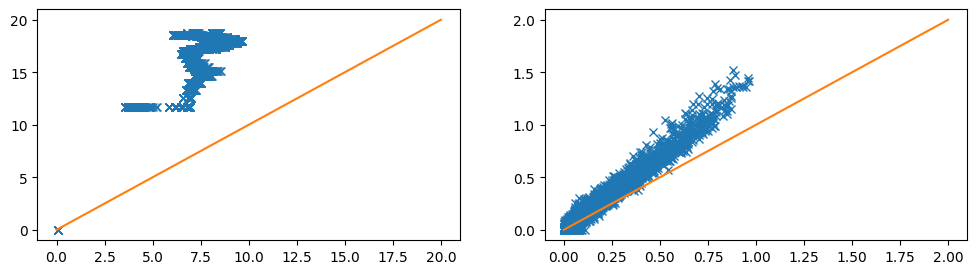


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2394     0  2393   2.392D+01   2.710D+05
  F =   271035.15728920826     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.608  0.813E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.509  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.355  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

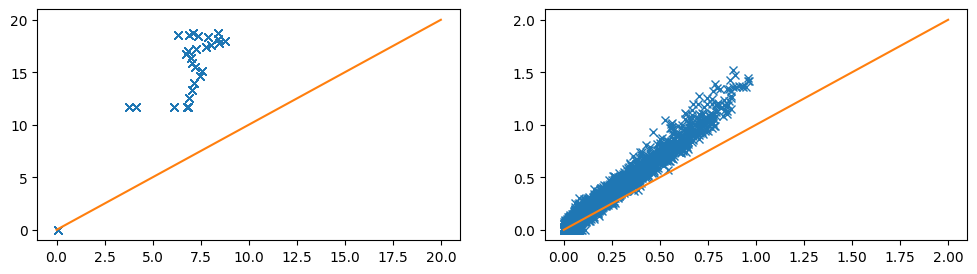

------ Iter 8 ------

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      9      1     0     0   2.171D+00   3.074D+05
  F =   307351.85425326490     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.608  0.813E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.509  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.355  0.816E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS

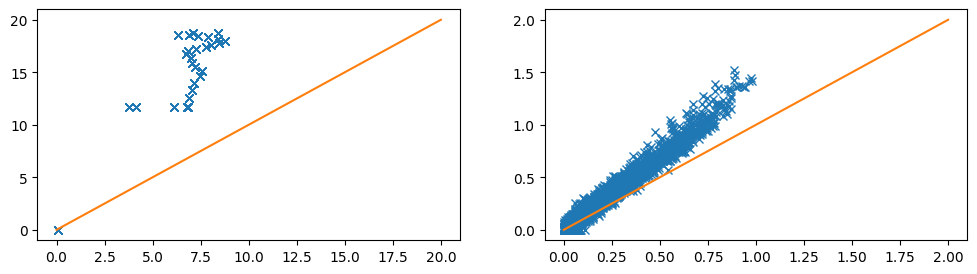


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7  23864     0 24694   4.880D+00   2.893D+01
  F =   28.930986475210599     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.603  0.830E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.500  0.833E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.341  0.833E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.603  0.830E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.500  0.833E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.341  0.833E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       831 variables are exactly at the bounds

At iterate    0    f=  2.89310D+01    |proj g|=  4.87996D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.599  0.831E-02    31968    35.78  0.140   [Radiance 0.660 micron]
     2  -3.560  0.841E-02    31968    35.78  0.140   [Radiance 0.660 micron]
     3  -5.440  0.841E-02    31968    35.78  0.140   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
  !

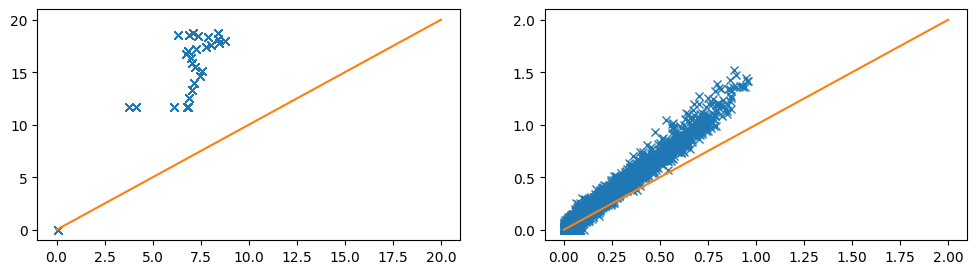


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7  24054     0 24884   3.230D+00   2.736D+01
  F =   27.358050119117447     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.605  0.826E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.505  0.828E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.350  0.828E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

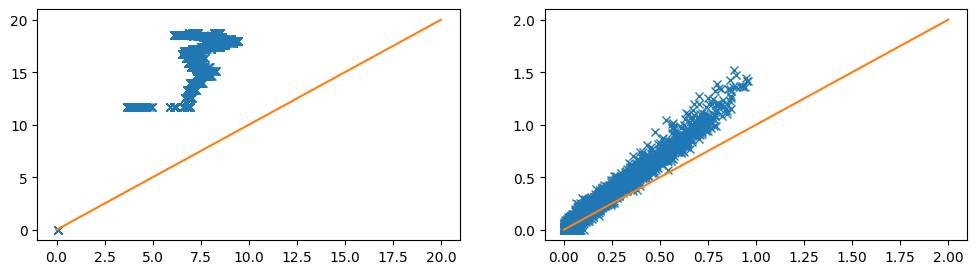


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2493     0  2492   2.387D+01   3.513D+05
  F =   351338.58539500239     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.605  0.826E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.506  0.829E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.351  0.829E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.605  0.826E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.506  0.829E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.351  0.829E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       831 variables are exactly at the bounds

At iterate    0    f=  4.09566D+01    |proj g|=  4.95162D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.488  0.132E-01    31968    35.58  0.139   [Radiance 0.660 micron]
     2  -3.291  0.132E-01    31968    35.58  0.139   [Radiance 0.660 micron]
     3  -4.993  0.132E-01    31968    35.58  0.139   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  !

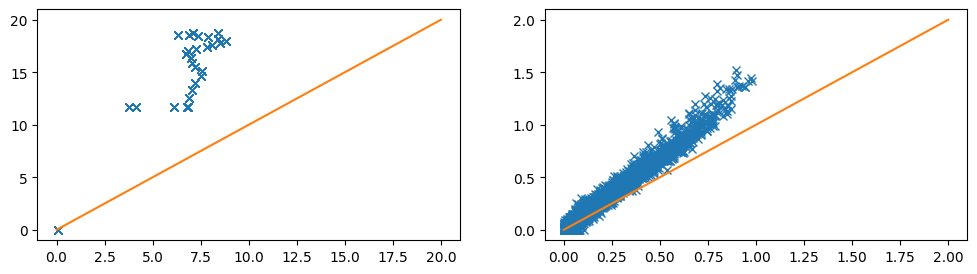


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      7  24080     0 24910   5.535D+00   4.049D+01
  F =   40.491418751599873     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.600  0.849E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.497  0.852E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.336  0.852E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.600  0.849E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     2  -3.497  0.852E-02    31968   221.62  0.866   [Radiance 0.660 micron]
     3  -5.336  0.852E-02    31968   221.62  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28350     M =           10

At X0       831 variables are exactly at the bounds

At iterate    0    f=  4.04914D+01    |proj g|=  5.53474D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.599  0.834E-02    31968    33.21  0.130   [Radiance 0.660 micron]
     2  -3.535  0.842E-02    31968    33.21  0.130   [Radiance 0.660 micron]
     3  -5.388  0.842E-02    31968    33.21  0.130   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]
  !

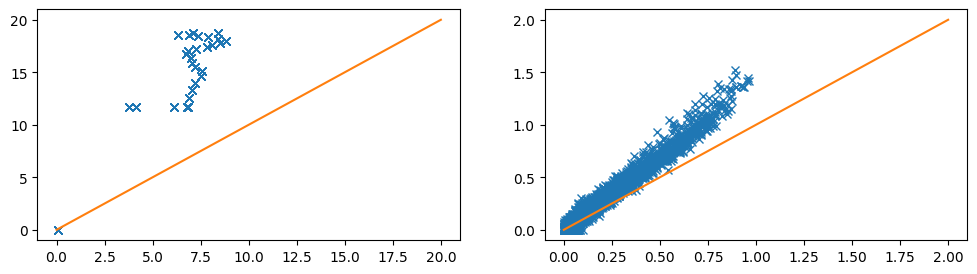


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      8  24390     0 25217   2.469D+00   3.915D+01
  F =   39.153575653267062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.602  0.843E-02    31968   221.65  0.866   [Radiance 0.660 micron]
     2  -3.502  0.846E-02    31968   221.65  0.866   [Radiance 0.660 micron]
     3  -5.344  0.846E-02    31968   221.65  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

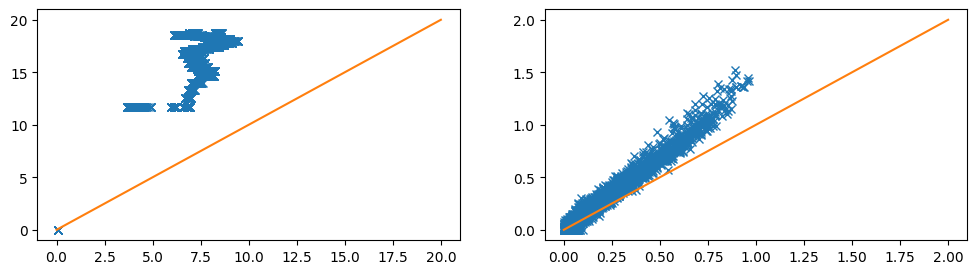


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350      1      4   2723     0  2722   2.535D+01   4.703D+05
  F =   470308.79900879582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.602  0.843E-02    31968   221.65  0.866   [Radiance 0.660 micron]
     2  -3.502  0.846E-02    31968   221.65  0.866   [Radiance 0.660 micron]
     3  -5.345  0.846E-02    31968   221.65  0.866   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           *

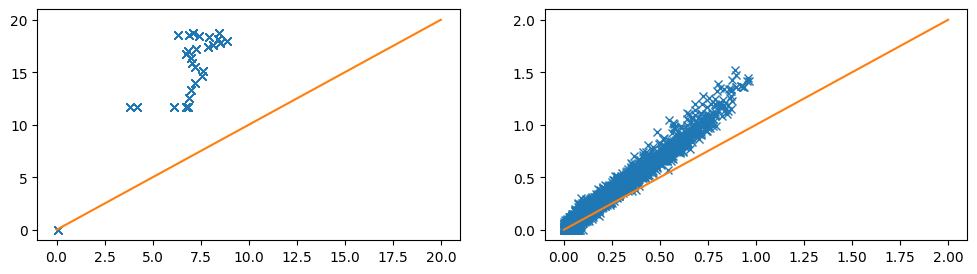


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27      1      6      1     0     0   3.068D+00   5.045D+05
  F =   504493.35490228783     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [5]:
import copy
solvers_reconstruct = copy.deepcopy(solvers)
solvers_reconstruct[.66].medium['cloud'].veff.data = carved_volume.mask.data.astype(float)*0 + .1
solvers_reconstruct[.66].medium['cloud'].reff.data = carved_volume.mask.data.astype(float)*0 + 10
solvers_reconstruct[.66].medium['cloud'].density.data = carved_volume.mask.data.astype(float)*0 + 0
iter = 10
for i in range(iter):
    print("------ Iter " + str(i) + " ------")
    solvers_reconstruct = train_density(solvers_reconstruct, 1.5**i)
    solvers_reconstruct = train_reff(solvers_reconstruct, 1.5**i)
    solvers_reconstruct = train_density(solvers_reconstruct, 1.5**i)
    solvers_reconstruct = train_reff_full(solvers_reconstruct, 1.5**i)
    solvers_reconstruct = train_reff(solvers_reconstruct, 1.5**i)